Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Acknowledgements

Done in collaboration with @giovanni-violo

# Problem description

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [128]:
from random import choices
import random
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt

import lab9_lib

## Evolution Strategy

Meaning the functions to apply an evolutionary algorithm to the problem.

We parametrized the algorithm with the following parameters:

In [129]:
# General Parameters
N_LOCI = 1000                       # number of loci in the chromosome
POPULATION_SIZE = 4                 # number of parents from which we generate offspring
OFFSPRING_SIZE = 6                  # number of offspring generated from parents
GENETIC_OPS_PROB_SELECTION = 0.5    # probability of selecting a specific genetic operator
BEST_FITNESS_THRESHOLD = 1        # threshold for the best fitness value to stop the algorithm
MAX_GENERATIONS = 5000              # maximum number of generations to run the algorithm

# Recombination parameters
RECOMBINATION_SLICE_SIZE = 500      # size of the first slice of the parent chromosome to be swapped with the other parent 

# Mutation parameters
MUTATION_SLICE_SIZE = 100           # number of bits to mutate

### Parent selection

To generate individuals we need to select parents. We used the following method:

- with a probability of 50% we select the **best** two individuals in the population.
- with a probability of 50% we select two **random** individuals in the population.

This should give us a good balance between offspring generated from the best individuals and offspring generated from random individuals. 
It is important given the heavily stochastic nature of the algorithm we implemented that cannot ensure that the best individuals are generated by the best parents.

In [130]:
def parent_selection(population):
    pop = population.copy()
    prob = random.random()
    random.shuffle(pop)
    pop = sorted(pop, key = lambda x: x[1]) if prob > 0.5 else pop
    return (pop[0], pop[1])

### Recombination

Parents are sliced in two parts and the first part of the first parent is combined with the second part of the second parent to generate the first offspring. The second offspring is generated in the same way but with the second part of the first parent and the first part of the second parent.

The slice point is defined by the ```RECOMBINATION_SLICE_SIZE``` parameter.

In [131]:
def recombine(parent1, parent2):
    return (
        parent1[:RECOMBINATION_SLICE_SIZE] + parent2[RECOMBINATION_SLICE_SIZE:],
        parent2[:RECOMBINATION_SLICE_SIZE] + parent1[RECOMBINATION_SLICE_SIZE:]
    )

### Mutation

The mutation is a simple bit flip of ```MUTATION_SLICE_SIZE``` random bits of the offspring.

In [132]:
def mutate(parent):
    offspring = parent.copy()
    random_gene_indexes = random.sample(range(0, N_LOCI), MUTATION_SLICE_SIZE)
    for g in random_gene_indexes:
        offspring[g] = 1 - offspring[g]
    return offspring

### Generation of individuals

The algorithm generates ```OFFSPRING_SIZE``` offspring from the parents.

Until the ```individuals``` array is full, the algorithm selects two parents and generates two offspring from them. 

The genetic operator is choosen randomly between ricombination and mutation with a probability of ```GENETIC_OPS_PROB_SELECTION``` for each.

In [133]:
def generate_individuals(population):
    """
    Generate individuals for the simulation.

    :return: A list of individuals.
    """
    individuals = []
    while len(individuals) < OFFSPRING_SIZE:
        parents = parent_selection(population)
        if random.random() > GENETIC_OPS_PROB_SELECTION:
            new_offs = recombine(parents[0][0], parents[1][0])
        else: 
            new_offs = (mutate(parents[0][0]), mutate(parents[1][0]))
        individuals.append(new_offs[0])
        individuals.append(new_offs[1])

    return individuals

### Survival selection

We chose to adopt a **plus strategy**, meaning that each generation we select the best ```POPULATION_SIZE``` individuals from the union of parents and offsprings. Of course we select the best individuals of the union.

In [134]:
def natural_selection(population):
    """
    Perform natural selection on the population using a 'plus' strategy

    :return: The population after natural selection.
    """
    return sorted(population, key=lambda x: x[1], reverse=True)[:POPULATION_SIZE]

## Algorithm

The algorithm is a local search algorithm that uses the evolution strategy described above to generate and select new individuals. At the end of each generation we select the best individual to check if its fitness is better than a ```BEST_FITNESS_THRESHOLD```. If it is, we stop the algorithm and return the individual. If it is not, we continue until we reach the ```MAX_GENERATIONS``` limit.

In [135]:
def solve_problem(problem_instance):
    history = []
    fitness = lab9_lib.make_problem(problem_instance)

    population = []
    for _ in range(POPULATION_SIZE):
        individual = [random.randint(0, 1) for _ in range(N_LOCI)]
        population.append((individual, fitness(individual)))
        
    best_individual = population[0]

    while best_individual[1] < BEST_FITNESS_THRESHOLD and len(history) < MAX_GENERATIONS:
        offsprings = generate_individuals(population)
        population += [(individual, fitness(individual)) for individual in offsprings]
        history.append(population.copy())
        population = natural_selection(population)
        best_individual = population[0]
    
    print(f"Best individual fitness: {best_individual[1]:.2%}")
    print("Generations: " + str(len(history)))
    print("Total fitness calls: " + str(fitness.calls))
    
    return history

### Plot

In [136]:
def plot(history):
        avgs =[]
        for gen in history:        
                sum = 0
                for el in gen:
                        sum += el[1]
                avg = sum/len(gen)
                avgs.append(avg)

        maxs = []
        for gen in history:
                max = 0
                for el in gen:
                        max = el[1] if el[1] > max else max
                maxs.append(max)

        plt.plot(range(len(maxs)), maxs)
        plt.show()
        plt.plot(range(len(avgs)), avgs)
        plt.show()

## Main

Best individual fitness: 27.90%
Generations: 5000
Total fitness calls: 30004


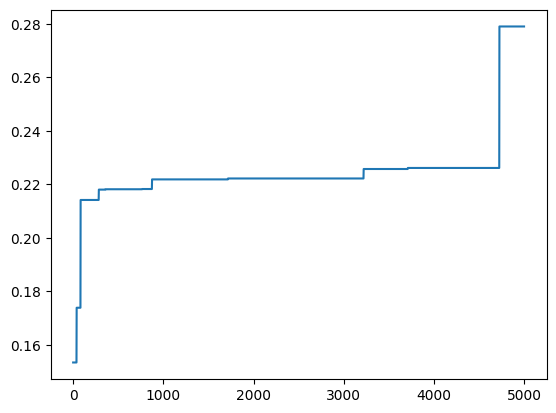

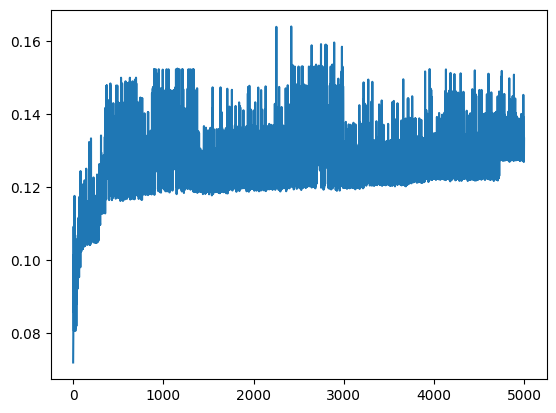

In [139]:
for _ in range(1):
    plot(solve_problem(5))
